In [76]:
!pip install pandas==2.2.3 tensorflow==2.19.0 scikit-learn==1.5.2 imbalanced-learn==0.13.0 scikeras==0.13.0

In [128]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score,f1_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, concatenate
from tensorflow.keras.models import Model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import PredefinedSplit
from sklearn.utils.class_weight import compute_class_weight



In [78]:
df = pd.read_csv('actu_finance.csv',index_col=0)
df.index = pd.to_datetime(df.index)
df.head()

,ORA_ACTU,GLE_ACTU,ALO_ACTU,KER_ACTU,CAP_ACTU,AIR_ACTU,CS_ACTU,BNP_ACTU,ORA_RDMT_5,GLE_RDMT_5,ALO_RDMT_5,KER_RDMT_5,CAP_RDMT_5,AIR_RDMT_5,CS_RDMT_5,BNP_RDMT_5
2017-01-02,NR,NR,NR,Nouveau record absolu à 216.3E (CF),NR,NR,Cession de Bluefin finalisée au Royaume-Uni (CF),Un nouveau responsable pour l'Allemagne (CF) |...,0.014413,-0.014924,0.001136,-0.001385,0.001364,0.039159,0.019677,0.013919
2017-01-04,Partenariat avec PSA et Ericsson (CF),NR,NR,NR,NR,NR,NR,Real Estate participe au CES (CF) | Franchit l...,-0.003740,-0.038147,0.010015,0.055372,-0.000997,0.032492,-0.015173,-0.034713
2017-01-05,NR,"Pic sans lendemain vers 49,375E (CF)",NR,NR,BlackRock dépasse les 5% (CF),Bien orienté grâce à des relèvements de broker...,NR,Nomination chez Real Estate (CF),-0.001014,-0.025902,-0.000381,0.080391,-0.004349,0.001393,-0.031775,-0.026840
2017-01-09,NR,Pullback jusque sur 46E (CF) | Nomination en I...,Contrat au Mexique (CF),NR,BlackRock repasse au-dessus de 5% (CF) | Black...,NR,NR,NR,0.009134,0.001190,-0.001892,0.045759,-0.017209,-0.001532,-0.035141,0.000327
2017-01-11,NR,NR,Retenu avec Bombardier pour le réseau francili...,"Nouveau 'gap' haussier, au dessus des 218E (CF...",BlackRock passe sous les 5% (CF),Iran Air réceptionne son premier A321 (CF) | G...,NR,NR,0.021843,-0.018968,-0.031244,0.015022,-0.032327,-0.009471,-0.048891,-0.015341


Le jeu de données contient des informations journalières de 2017 à 2023 sur 8 entreprises du CAC 40. Pour chaque jour, il indique s’il y a eu une actualité concernant chaque entreprise (colonne `X_ACTU`) ou non (valeur "NR"). Lorsqu’une actualité est présente, elle est décrite sous forme de titre. En parallèle, chaque ligne fournit le rendement boursier à 5 jours ouvrés pour chaque entreprise (colonne `X_RDMT_5`). Ainsi, les données permettent d’étudier l’impact potentiel d’une actualité sur le rendement futur d’un actif, en combinant texte (actualités) et données financières (rendements).

In [79]:

print("Valeurs manquantes par colonne :")
df.isnull().sum()


Valeurs manquantes par colonne :


ORA_ACTU      0
GLE_ACTU      0
ALO_ACTU      0
KER_ACTU      0
CAP_ACTU      0
AIR_ACTU      0
CS_ACTU       0
BNP_ACTU      0
ORA_RDMT_5    0
GLE_RDMT_5    0
ALO_RDMT_5    0
KER_RDMT_5    0
CAP_RDMT_5    0
AIR_RDMT_5    0
CS_RDMT_5     0
BNP_RDMT_5    0
dtype: int64

On Observe que les variables sont non nulles, mais que certaines d'entre elles sont des `NR`.

In [80]:

print("Résumé statistique :")
display(df.describe(exclude=[object]))
df.describe(include=[object])


Résumé statistique :


,ORA_RDMT_5,GLE_RDMT_5,ALO_RDMT_5,KER_RDMT_5,CAP_RDMT_5,AIR_RDMT_5,CS_RDMT_5,BNP_RDMT_5
count,1674.000000,1674.000000,1674.000000,1674.000000,1674.000000,1674.000000,1674.000000,1674.000000
mean,-0.000773,-0.000820,-0.000899,0.002520,0.003427,0.003318,0.001266,0.000680
std,0.027210,0.054832,0.049394,0.044154,0.042971,0.051081,0.039878,0.046380
min,-0.221232,-0.317709,-0.412320,-0.233300,-0.297323,-0.427480,-0.281625,-0.259675
25%,-0.014176,-0.025203,-0.022386,-0.022415,-0.016387,-0.018847,-0.016342,-0.021449
50%,-0.000208,0.001178,0.000956,0.005328,0.004030,0.003510,0.002948,0.001196
75%,0.014105,0.028049,0.024353,0.026196,0.024732,0.024978,0.020554,0.025079
max,0.190172,0.281014,0.222395,0.320190,0.338290,0.428219,0.309108,0.277626


,ORA_ACTU,GLE_ACTU,ALO_ACTU,KER_ACTU,CAP_ACTU,AIR_ACTU,CS_ACTU,BNP_ACTU
count,1674,1674,1674,1674,1674,1674,1674,1674
unique,572,504,632,376,513,1004,409,459
top,NR,NR,NR,NR,NR,NR,NR,NR
freq,1087,1164,1039,1297,1138,670,1234,1207


In [81]:
assets = [x.split("_")[0] for x in df.columns[df.columns.str.endswith('ACTU')]]
assets

['ORA', 'GLE', 'ALO', 'KER', 'CAP', 'AIR', 'CS', 'BNP']

In [82]:
def get_news_statistics(asset):
    news_col = asset + "_ACTU"
    rdmt_col = asset + "_RDMT_5"
    df_news = df[df[news_col] != "NR"]

    count_news = df_news.shape[0]
    total_rows = df.shape[0]
    perc_news = count_news / total_rows * 100

    stats_rdmt = df_news[rdmt_col].describe()
    desc_stats = {
        "Count_News": count_news,
        "Total_Rows": total_rows,
        "Percent_News": perc_news,
        "Returns_Stats": stats_rdmt
    }

    return desc_stats

desc_stats = {}
for asset in assets:

    desc_stats[asset] = get_news_statistics(asset)
    print(f"Actif : {asset}")
    print(f"  Nombre d'actualités (≠ 'NR') : {desc_stats[asset]['Count_News']} sur {desc_stats[asset]['Total_Rows']} lignes ({desc_stats[asset]['Percent_News']:.2f}%)")
    print("  Statistiques descriptives du rendement (quand actualité présente) :")
    print(desc_stats[asset]['Returns_Stats'])
    print("-" * 50)


Actif : ORA
  Nombre d'actualités (≠ 'NR') : 587 sur 1674 lignes (35.07%)
  Statistiques descriptives du rendement (quand actualité présente) :
count    587.000000
mean       0.000341
std        0.025138
min       -0.089933
25%       -0.014465
50%        0.000613
75%        0.014698
max        0.158930
Name: ORA_RDMT_5, dtype: float64
--------------------------------------------------
Actif : GLE
  Nombre d'actualités (≠ 'NR') : 510 sur 1674 lignes (30.47%)
  Statistiques descriptives du rendement (quand actualité présente) :
count    510.000000
mean      -0.003006
std        0.054395
min       -0.245283
25%       -0.027137
50%       -0.000327
75%        0.025619
max        0.281014
Name: GLE_RDMT_5, dtype: float64
--------------------------------------------------
Actif : ALO
  Nombre d'actualités (≠ 'NR') : 635 sur 1674 lignes (37.93%)
  Statistiques descriptives du rendement (quand actualité présente) :
count    635.000000
mean      -0.000393
std        0.056169
min       -0.412168


L'analyse des statistiques montre une variation notable de la fréquence des actualités selon les actifs, allant de 22 % pour **KER** à près de 60 % pour **AIR**. Malgré ces différences, les rendements moyens à 5 jours après une actualité restent globalement faibles, oscillant autour de zéro, avec **BNP** affichant le rendement moyen le plus élevé (0.0043) et **GLE** un rendement négatif (-0.0030). La volatilité, mesurée par l'écart-type, varie également : **ALO** et **GLE** présentent une forte dispersion des rendements (écarts-types supérieurs à 0.05), tandis que **ORA**, **CS** et **CAP** sont plus stables. Ces résultats suggèrent que les actualités influencent différemment les actifs, certaines entreprises réagissant plus fortement que d’autres en termes de rendements boursiers.

In [83]:
for asset in assets:
    news_col = asset + "_ACTU"
    news_per_year = df[df[news_col] != "NR"][[news_col]].reset_index(names="date").groupby(pd.Grouper(key="date", freq="YE")).size() #ME for monthly
    print(f"Actualités pour {asset} par année :")
    print(news_per_year)
    print("-" * 50)

Actualités pour ORA par année :
date
2017-12-31    69
2018-12-31    78
2019-12-31    81
2020-12-31    88
2021-12-31    94
2022-12-31    93
2023-12-31    84
Freq: YE-DEC, dtype: int64
--------------------------------------------------
Actualités pour GLE par année :
date
2017-12-31    96
2018-12-31    77
2019-12-31    80
2020-12-31    63
2021-12-31    62
2022-12-31    66
2023-12-31    66
Freq: YE-DEC, dtype: int64
--------------------------------------------------
Actualités pour ALO par année :
date
2017-12-31     98
2018-12-31     84
2019-12-31     83
2020-12-31     67
2021-12-31     96
2022-12-31     92
2023-12-31    115
Freq: YE-DEC, dtype: int64
--------------------------------------------------
Actualités pour KER par année :
date
2017-12-31    50
2018-12-31    61
2019-12-31    46
2020-12-31    49
2021-12-31    47
2022-12-31    59
2023-12-31    65
Freq: YE-DEC, dtype: int64
--------------------------------------------------
Actualités pour CAP par année :
date
2017-12-31    56
201

L'analyse de la répartition annuelle des actualités révèle des dynamiques contrastées entre les actifs. AIR se distingue par une couverture médiatique très soutenue et stable, avec plus de 130 actualités par an, tandis que ALO affiche une tendance haussière notable, atteignant un pic en 2023. À l’inverse, BNP et GLE montrent une baisse progressive du nombre d’actualités depuis 2017, traduisant possiblement un désintérêt relatif ou une actualité moins fréquente. D'autres actifs comme ORA, CAP et KER présentent une fréquence plus modérée et relativement stable, sans variations majeures. Ces tendances peuvent refléter la visibilité médiatique des entreprises, leur volatilité opérationnelle ou l'intérêt des marchés à leur égard.









In [84]:
df_desc_stats = pd.DataFrame(desc_stats).T.sort_values("Percent_News", ascending=False).T

In [85]:
df_desc_stats

,AIR,ALO,ORA,CAP,GLE,BNP,CS,KER
Count_News,1004,635,587,536,510,467,440,377
Total_Rows,1674,1674,1674,1674,1674,1674,1674,1674
Percent_News,59.976105,37.933094,35.065711,32.019116,30.46595,27.897252,26.284349,22.520908
Returns_Stats,count 1004.000000 mean 0.002403 std ...,count 635.000000 mean -0.000393 std ...,count 587.000000 mean 0.000341 std ...,count 536.000000 mean 0.002953 std ...,count 510.000000 mean -0.003006 std ...,count 467.000000 mean 0.004333 std ...,count 440.000000 mean 0.001598 std ...,count 377.000000 mean 0.002142 std ...


L’analyse croisée du volume d’actualités et des rendements permet de dégager quelques tendances claires. AIR est l’actif le plus fréquemment couvert, avec près de 60 % des jours associés à une actualité, suivi par ALO et ORA autour de 35-38 %. En revanche, KER et CS apparaissent comme les moins médiatisés, avec moins de 27 % de jours couverts. Sur le plan des rendements, BNP présente la performance moyenne la plus élevée (0.0043), malgré une couverture modérée (28 %), ce qui pourrait indiquer une plus forte sensibilité aux nouvelles. À l’opposé, GLE affiche un rendement moyen négatif, suggérant que ses actualités sont peut-être perçues comme défavorables par le marché. Globalement, la fréquence des actualités ne semble pas directement liée au rendement moyen, mais certains actifs comme CAP ou KER montrent un bon compromis entre couverture et performance, ce qui peut en faire des cibles intéressantes pour l'analyse.









In [86]:
chosen_assets = df_desc_stats.columns[:5]

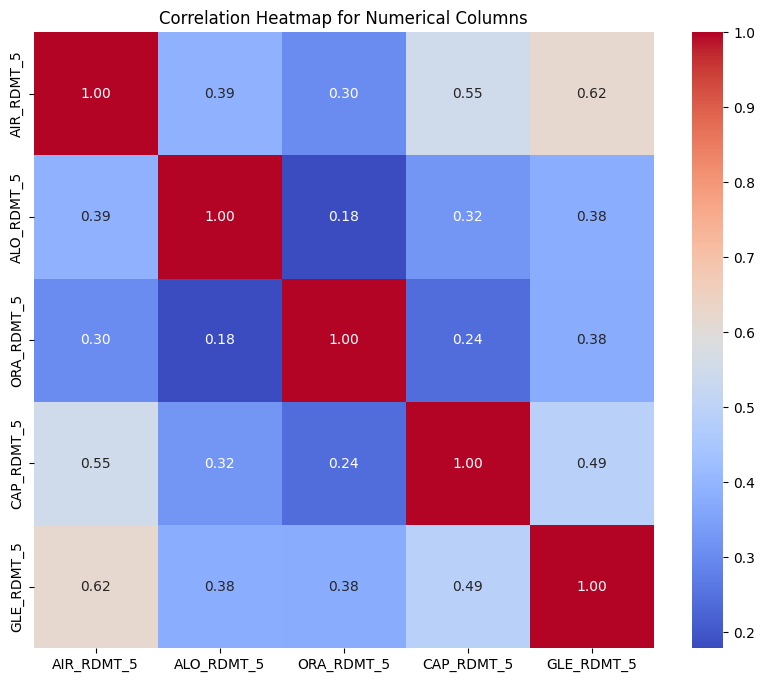

In [87]:

numerical_cols = df[[x+"_RDMT_5" for x in chosen_assets]]

corr_matrix = numerical_cols.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap for Numerical Columns")
plt.show()

La heatmap révèle des corrélations notables entre certains actifs, notamment **AIR**, **GLE** et **CAP**, qui affichent des coefficients élevés (jusqu’à 0.62 entre AIR et GLE). Cela suggère qu’ils réagissent souvent de manière similaire aux conditions de marché ou partagent des influences sectorielles communes. À l’inverse, **ORA** et **ALO** présentent des corrélations plus faibles avec les autres actifs, ce qui indique des dynamiques plus indépendantes. Ces différences de comportements peuvent refléter des expositions sectorielles variées ou une sensibilité différenciée aux actualités. Une telle analyse est précieuse pour identifier les actifs à combiner dans une approche de diversification ou pour mieux comprendre les transmissions d’information entre titres.

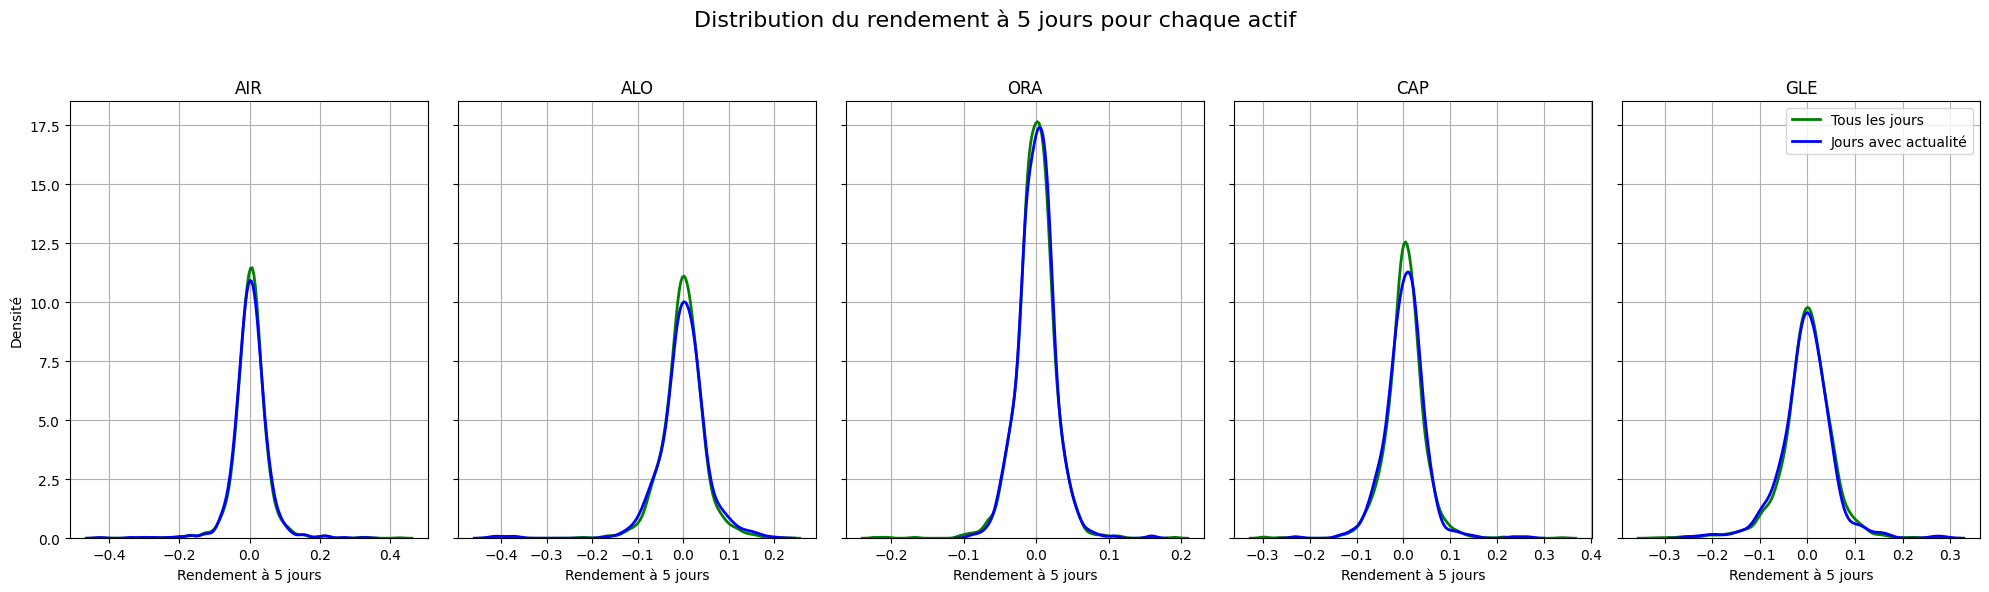

In [88]:

fig, axes = plt.subplots(1, len(chosen_assets), figsize=(20, 6), sharey=True)

for i, asset in enumerate(chosen_assets):
    news_col = asset + "_ACTU"
    rdmt_col = asset + "_RDMT_5"

    df_with_news = df[df[news_col] != "NR"][rdmt_col]
    df_all = df[rdmt_col]

    sns.kdeplot(df_all, label='Tous les jours', color='green', linewidth=2, ax=axes[i])
    sns.kdeplot(df_with_news, label='Jours avec actualité', color='blue', linewidth=2, ax=axes[i])
    axes[i].set_title(f"{asset}")
    axes[i].set_xlabel("Rendement à 5 jours")
    axes[i].grid(True)

axes[0].set_ylabel("Densité")
fig.suptitle("Distribution du rendement à 5 jours pour chaque actif", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
axes[-1].legend(loc='upper right')
plt.show()


Le graphique montre la distribution des rendements à 5 jours pour chaque actif, en distinguant les jours avec actualité (en bleu) de l’ensemble des jours (en vert). On observe que, pour tous les actifs, la forme des distributions reste globalement similaire entre les deux cas, ce qui suggère que la présence d'une actualité n'entraîne pas systématiquement de changement majeur dans la distribution des rendements. Cependant, quelques différences légères sont visibles : par exemple, pour CAP et ALO, les jours avec actualité semblent légèrement plus dispersés, laissant penser que les nouvelles peuvent accroître la volatilité. Pour ORA, la courbe bleue est très proche de la verte, indiquant une faible sensibilité du rendement aux actualités. Cette visualisation illustre que l’effet des actualités sur le rendement est subtil et dépend de l’actif, ce qui justifie l’intérêt d’un modèle de prédiction plus avancé basé sur le contenu textuel.









C:\Users\amine\AppData\Local\Temp\ipykernel_21296\764485843.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=plot_df, x="Asset", y="Mean Return", hue="Type", palette="viridis", ci=None)


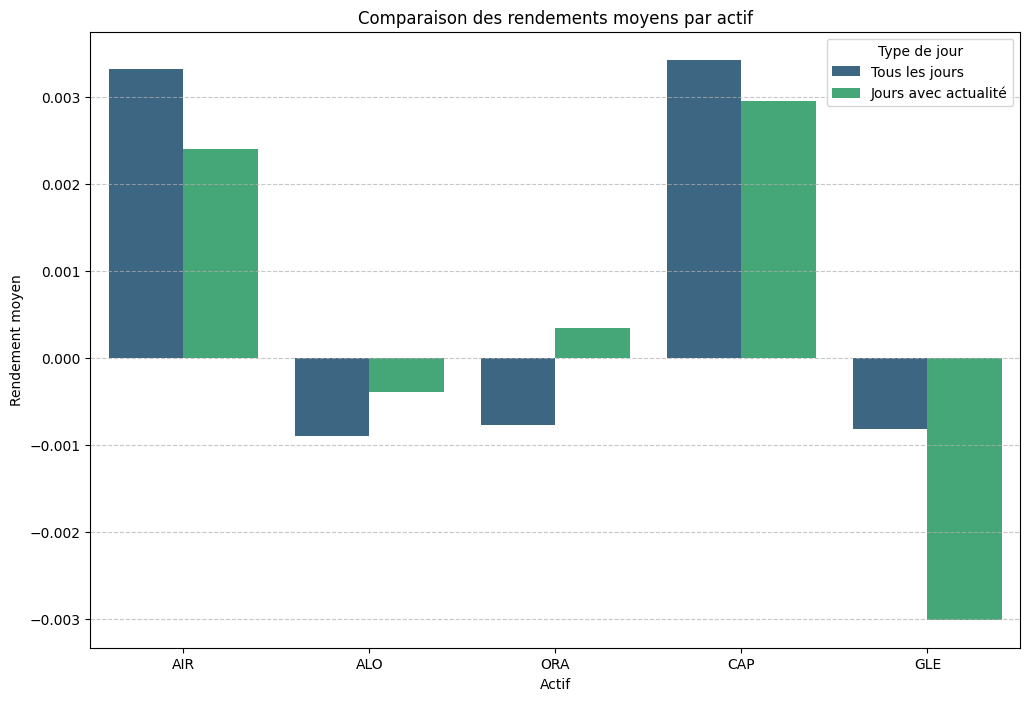

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
data = []
for asset in chosen_assets:
    news_col = asset + "_ACTU"
    rdmt_col = asset + "_RDMT_5"

    df_with_news = df[df[news_col] != "NR"][rdmt_col]
    df_all = df[rdmt_col]

    data.append({
        "Asset": asset,
        "Type": "Tous les jours",
        "Mean Return": df_all.mean(),
        "Std Return": df_all.std()
    })
    data.append({
        "Asset": asset,
        "Type": "Jours avec actualité",
        "Mean Return": df_with_news.mean(),
        "Std Return": df_with_news.std()
    })

# Convert to DataFrame for easier plotting
plot_df = pd.DataFrame(data)

# Plot grouped bar chart
plt.figure(figsize=(12, 8))
sns.barplot(data=plot_df, x="Asset", y="Mean Return", hue="Type", palette="viridis", ci=None)
plt.title("Comparaison des rendements moyens par actif")
plt.ylabel("Rendement moyen")
plt.xlabel("Actif")
plt.legend(title="Type de jour")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Le graphique compare les rendements moyens sur l’ensemble des jours versus les jours avec actualité pour chaque actif. On observe que, pour CAP et AIR, les rendements restent positifs même en présence d’actualités, bien que légèrement inférieurs à ceux observés en moyenne générale. ORA présente un changement intéressant : le rendement moyen devient positif les jours avec actualité, contrairement au rendement global qui est légèrement négatif. À l'inverse, GLE affiche une nette dégradation de performance lors des jours avec actualité, passant d’un léger rendement négatif à un rendement fortement négatif, suggérant un impact potentiellement défavorable des nouvelles sur cet actif. Enfin, ALO montre une amélioration modérée lors des jours avec actualité, bien que le rendement reste proche de zéro. Ces résultats suggèrent que l'effet des actualités varie fortement selon l'actif, justifiant une modélisation individualisée.









In [90]:
import requests
url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-fr/refs/heads/master/stopwords-fr.txt"

response = requests.get(url)
response.raise_for_status()
french_stopwords = set(response.text.splitlines())


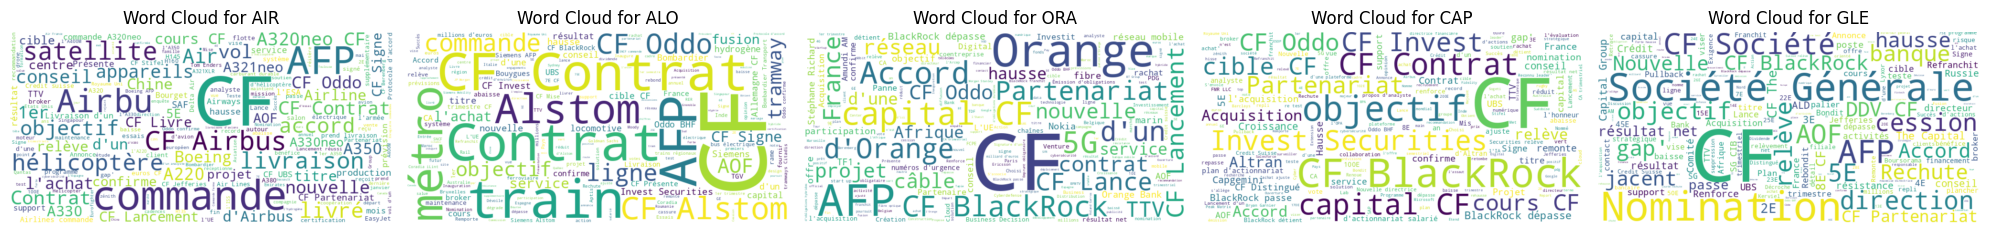

In [91]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Create a word cloud for each asset's actualities
fig, axes = plt.subplots(1, len(chosen_assets), figsize=(20, 6))

for i, asset in enumerate(chosen_assets):
    news_col = asset + "_ACTU"
    text = " ".join(df[df[news_col] != "NR"][news_col].dropna())

    wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=french_stopwords).generate(text)

    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].set_title(f"Word Cloud for {asset}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

Pour les actu de GLE on voir que Societe Generale est tres montione dans les actualités. ce qui peut expliquer la correlation entre les rendements de GLE et ceux de BNP.

Les nuages de mots mettent en évidence les termes les plus fréquents dans les actualités par actif, révélant des thématiques spécifiques. Pour AIR, les mots comme commande, livraison, hélicoptère et Airbus dominent, soulignant une actualité centrée sur la production aéronautique. ALO met l’accent sur train, métro et contrat, ce qui reflète clairement l’activité d’Alstom dans le ferroviaire. Du côté d’ORA, on retrouve Orange, capital et partenariat, illustrant des opérations financières ou stratégiques fréquentes. CAP est fortement lié aux termes BlackRock, objectif et acquisition, ce qui peut traduire une actualité tournée vers les marchés et les perspectives financières. Enfin, pour GLE, des mots comme Société Générale, nomination, direction et cession apparaissent fréquemment, suggérant une couverture orientée sur la gouvernance et les restructurations internes. Ces insights textuels enrichissent la compréhension des signaux potentiels derrière les rendements.









<Axes: title={'center': 'Distribution de la cible Y'}, xlabel='Y'>

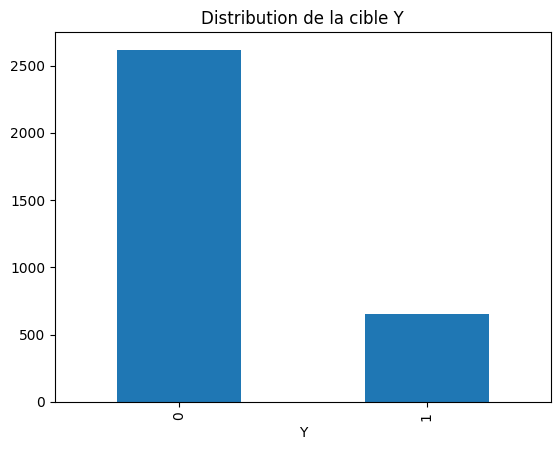

In [92]:

top_assets = chosen_assets

# Étape 2 : construire le dataset concaténé {ACTU, RDMT_5}
rows = []
for asset in top_assets:
    sub_df = df[df[f"{asset}_ACTU"] != "NR"]
    rows.append(sub_df[[f"{asset}_ACTU", f"{asset}_RDMT_5"]].rename(columns={f"{asset}_ACTU": "ACTU", f"{asset}_RDMT_5": "RDMT_5"}))

data = pd.concat(rows).reset_index()

# Création de Y à partir du quantile 80%
q80 = data["RDMT_5"].quantile(0.80)
data["Y"] = (data["RDMT_5"] > q80).astype(int)

data["Y"].value_counts().plot(kind="bar", title="Distribution de la cible Y")

Le graphique montre une distribution déséquilibrée de la variable cible Y, construite selon la stratégie 1 : la classe 1 (rendements dans le top 20 %) représente environ 20 % des données, contre 80 % pour la classe 0. Ce déséquilibre, attendu vu l’usage d’un quantile, constitue un défi pour l’apprentissage supervisé. Bien que des techniques comme SMOTE ou ADASYN soient courantes, elles ne sont pas adaptées ici car nos données sont des séquences de tokens entiers, non continues. Interpoler entre des indices de mots ne produit pas de texte valide et risque d’ajouter du bruit. On privilégiera donc la pondération des classes ou le sous-échantillonnage.


---

# Modeling


# Data Loading and Preparation


In [93]:

X_text = data["ACTU"].values  # text data
y = data["Y"].values          # binary target




# Custom Transformer: Text Preprocessing


In [94]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    """
    Ce transformateur permet de tokeniser et de padder les données textuelles.
    """
    def __init__(self, num_words=5000, maxlen=30, tokenizer=None):
        self.num_words = num_words
        self.maxlen = maxlen
        if tokenizer is None:
            # Si aucun tokenizer n'est fourni, on en crée un nouveau avec un vocabulaire limité à num_words mots
            self.tokenizer = Tokenizer(num_words=self.num_words, lower=True)
            self._tokenizer_provided = False
        else:
            # Si un tokenizer est fourni, on l'utilise tel quel
            self.tokenizer = tokenizer
            self._tokenizer_provided = True

    def fit(self, X, y=None):
        # On ajuste le tokenizer uniquement s'il n'a pas été fourni pré-ajusté
        if not self._tokenizer_provided:
            self.tokenizer.fit_on_texts(X)
        return self

    def transform(self, X, y=None):
        # Convertit les textes en séquences d'entiers et applique un padding pour uniformiser la longueur
        sequences = self.tokenizer.texts_to_sequences(X)
        padded = pad_sequences(sequences, maxlen=self.maxlen)
        return padded


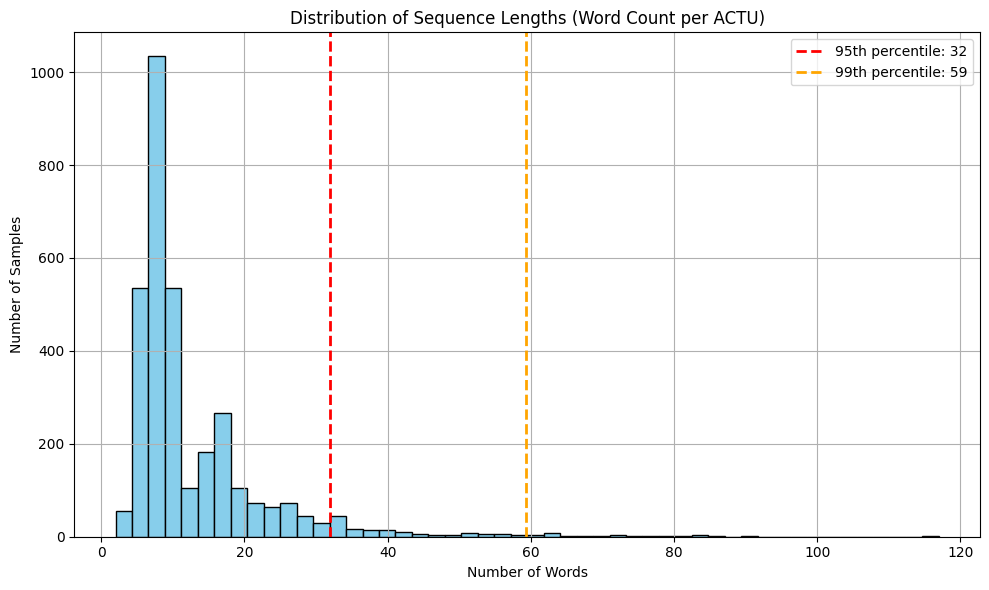

{50: np.float64(9.0),
 75: np.float64(16.0),
 90: np.float64(24.0),
 95: np.float64(32.0),
 99: np.float64(59.289999999999964)}

In [95]:
sequence_lengths = data["ACTU"].apply(lambda x: len(str(x).split()))

# Compute percentiles for determining the maximum sequence length
percents = [50, 75, 90, 95, 99]
percentiles = dict(zip(percents,np.percentile(sequence_lengths,percents )))

# Plot distribution of sequence lengths
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=50, color='skyblue', edgecolor='black')
plt.axvline(list(percentiles.values())[3], color='red', linestyle='dashed', linewidth=2, label=f'95th percentile: {list(percentiles.values())[3]:.0f}')
plt.axvline(list(percentiles.values())[4], color='orange', linestyle='dashed', linewidth=2, label=f'99th percentile: {list(percentiles.values())[4]:.0f}')
plt.title("Distribution of Sequence Lengths (Word Count per ACTU)")
plt.xlabel("Number of Words")
plt.ylabel("Number of Samples")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show();
percentiles


L’analyse de la longueur des titres d’actualités montre que ceux-ci sont généralement courts, avec une médiane à 9 mots et 95 % des titres contenant moins de 32 mots. Le 99ᵉ percentile atteint 59 mots, ce qui signifie que très peu de titres dépassent cette longueur. Ces informations sont essentielles pour le choix du paramètre `maxlen` lors du prétraitement des données textuelles. Un `maxlen` fixé à 32 permettrait de couvrir efficacement la grande majorité des cas tout en limitant le coût computationnel. Toutefois, pour une couverture maximale sans perte d’information, un `maxlen` de 30 peut être envisagé. Ce choix devra équilibrer précision du modèle et performance d’entraînement.

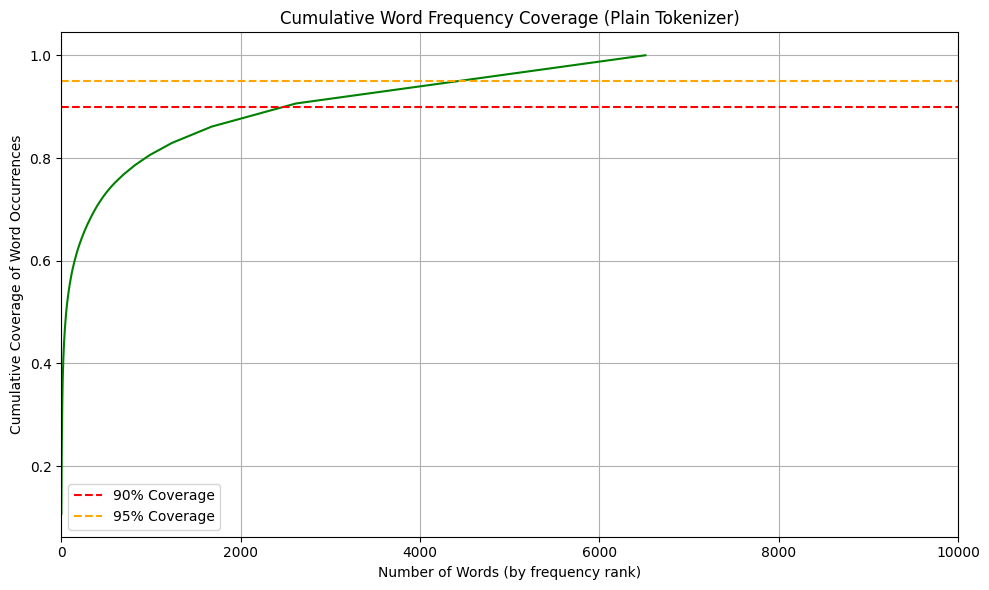

In [96]:
from collections import Counter

all_words = ' '.join(data['ACTU'].astype(str).str.lower()).split()
word_freq = Counter(all_words)

sorted_counts = sorted(word_freq.values(), reverse=True)
total_tokens = sum(sorted_counts)
cumulative = np.cumsum(sorted_counts) / total_tokens

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative) + 1), cumulative, color='green')
plt.xlabel("Number of Words (by frequency rank)")
plt.ylabel("Cumulative Coverage of Word Occurrences")
plt.title("Cumulative Word Frequency Coverage (Plain Tokenizer)")
plt.grid(True)
plt.xlim(0, 10000)
plt.axhline(y=0.90, color='red', linestyle='--', label="90% Coverage")
plt.axhline(y=0.95, color='orange', linestyle='--', label="95% Coverage")
plt.legend()
plt.tight_layout()
plt.show()

num_words_90 = np.argmax(cumulative >= 0.90) + 1
num_words_95 = np.argmax(cumulative >= 0.95) + 1


Ce graphique de couverture cumulative des occurrences de mots montre qu’un vocabulaire limité aux 5 000 mots les plus fréquents permet de capturer environ 95 % des occurrences totales dans les actualités. Ce choix est donc très pertinent pour le tokenizer, car il offre un bon compromis entre couverture lexicale et complexité du modèle.


# Model Building Functions


On définit plusieurs modèles de réseaux neuronaux profonds pour traitement du langage naturel (NLP).


1. **`create_bilstm_model`** : Ce modèle utilise une architecture BiLSTM (Long Short-Term Memory bidirectionnelle) pour capturer les dépendances contextuelles dans les deux directions d'une séquence. Il inclut une couche d'intégration (`Embedding`), deux couches BiLSTM, et des couches denses pour la classification.

2. **`create_lstm_model`** : Similaire au modèle précédent, mais utilise des couches LSTM unidirectionnelles au lieu de BiLSTM. Cela réduit la complexité tout en conservant une capacité d'apprentissage séquentiel.

3. **`build_hybrid_bilstm_textconvonet`** : Ce modèle hybride combine deux branches :
   - Une branche BiLSTM pour capturer les relations séquentielles.
   - Une branche CNN (réseau de neurones convolutifs) pour extraire des caractéristiques locales à l'aide de filtres de différentes tailles. Les deux branches sont fusionnées pour une classification finale.

4. **`build_textconvonet_model`** : Ce modèle est basé uniquement sur des couches CNN. Il applique plusieurs filtres convolutifs de tailles différentes sur les représentations intégrées, suivis d'un regroupement (`MaxPooling`) et d'une fusion des caractéristiques pour la classification.

Tous les modèles utilisent une fonction de perte `binary_crossentropy`, l'optimiseur `adam`, et des métriques comme l'AUC, le F1-score, le rappel et la précision pour évaluer leurs performances. Ces architectures sont adaptées aux tâches de classification de texte, comme l'analyse de sentiments ou la détection de spam.

In [97]:
def create_bilstm_model(embedding_dim=64,input_length=60, lstm_units=64, dense_units=32, num_words=5000, name="BiLSTM",**kwargs):
    model = models.Sequential(name=name)
    model.add(layers.Embedding(input_dim=num_words, output_dim=embedding_dim))
    model.add(layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(lstm_units // 2)))
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.build(input_shape=(None, input_length))
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=[
            tf.keras.metrics.AUC(name='auc'),
            tf.metrics.F1Score(average='weighted', threshold=0.5),
            "recall",
            "precision"
        ]
    )
    return model

def create_lstm_model(embedding_dim=64,input_length=60, lstm_units=64, dense_units=32, num_words=5000,name="LSTM",**kwargs):
    model = models.Sequential(name=name)
    model.add(layers.Embedding(input_dim=num_words, output_dim=embedding_dim))
    model.add(layers.LSTM(lstm_units, return_sequences=True))
    model.add(layers.LSTM(lstm_units // 2))
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.build(input_shape=(None, input_length))
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=[
            tf.keras.metrics.AUC(name='auc'),
            tf.metrics.F1Score(average='weighted', threshold=0.5),
            "recall",
            "precision"
        ]
    )
    return model


def build_hybrid_bilstm_textconvonet(embedding_dim=64, input_length=60,lstm_units=64, num_words=5000, name="Hybrid_BiLSTM_TextCNN",**kwargs):


    input_seq = Input(shape=(input_length,))
    embedding = Embedding(input_dim=num_words, output_dim=embedding_dim)(input_seq)

    # Branch 1: BiLSTM
    x1 = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding)
    x1 = Bidirectional(LSTM(lstm_units//2))(x1)

    # Branch 2: Conv2D
    reshape = Reshape((input_length, embedding_dim, 1))(embedding)
    convs = []
    for kernel_size in [2, 3, 4]:
        conv = Conv2D(filters=100, kernel_size=(kernel_size, embedding_dim), activation='relu')(reshape)
        pool = MaxPooling2D(pool_size=(input_length - kernel_size + 1, 1))(conv)
        convs.append(pool)
    x2 = concatenate(convs, axis=-1)
    x2 = Flatten()(x2)

    # Merge both branches
    merged = concatenate([x1, x2])
    dense = Dense(64, activation='relu')(merged)
    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=input_seq, outputs=output, name=name)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=[
            tf.keras.metrics.AUC(name='auc'),
            tf.metrics.F1Score(average='weighted', threshold=0.5),
            "recall",
            "precision"
        ]
    )
    return model


def build_textconvonet_model(embedding_dim=64, input_length=60, num_words=5000, name="TextConvoNet",**kwargs):
    """
    Builds a TextConvoNet-inspired model with multi-channel Conv2D filters over embedding inputs.
    """
    inputs = Input(shape=(input_length,))
    x = layers.Embedding(input_dim=num_words, output_dim=embedding_dim)(inputs)
    x = layers.Reshape((input_length, embedding_dim, 1))(x)  # Shape: (batch, height=seq_len, width=embed_dim, channels=1)

    # Multiple filter sizes
    convs = []
    for kernel_size in [2, 3, 4]:
        conv = layers.Conv2D(filters=100,
                             kernel_size=(kernel_size, embedding_dim),
                             activation='relu')(x)
        pool = layers.MaxPooling2D(pool_size=(input_length - kernel_size + 1, 1))(conv)
        convs.append(pool)

    merged = layers.concatenate(convs, axis=-1)
    flatten = layers.Flatten()(merged)
    dense = layers.Dense(64, activation='relu')(flatten)
    outputs = layers.Dense(1, activation='sigmoid')(dense)

    model = Model(inputs, outputs, name=name)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=[
            tf.keras.metrics.AUC(name='auc'),
            tf.metrics.F1Score(average='weighted', threshold=0.5),
            "recall",
            "precision"
        ]
    )
    return model



# Build the Pipeline and Grid Search


La classe `MyKerasClassifier` étend `KerasClassifier` pour s'intégrer à l'API de scikit-learn tout en ajoutant des fonctionnalités personnalisées. Elle redéfinit des méthodes pour assurer la compatibilité avec scikit-learn (`__sklearn_tags__`, `__sklearn_is_fitted__`) et implémente une méthode `score` personnalisée. Cette méthode évalue les performances du modèle en calculant les prédictions, en générant un rapport de classification, en calculant l'AUC (aire sous la courbe) et en affichant les résultats dans un DataFrame. Elle retourne le F1-score pondéré, adapté aux jeux de données déséquilibrés.

In [98]:
class MyKerasClassifier(KerasClassifier):
    def __sklearn_tags__(self):
        # Minimal tags to avoid calling super().__sklearn_tags__
        return {"requires_fit": True, "non_deterministic": True}

    def __sklearn_is_fitted__(self):
        # Check if model is fitted by looking for self.model_
        return hasattr(self, "model_") and self.model_ is not None

    def fit(self, X, y, **kwargs):
        result = super().fit(X, y, **kwargs)

        y_proba = self.predict_proba(X)[:, 1]
        if "opt_threshold" in kwargs and kwargs["opt_threshold"]:
          thresholds = np.linspace(0.1, 0.9, 81)
          f1_scores = [f1_score(y, (y_proba > t).astype(int),average="micro") for t in thresholds]
          self.optimal_threshold = thresholds[np.argmax(f1_scores)]
          print(f"Optimal threshold computed on training set: {self.optimal_threshold:.2f}")
        return result

    def score(self, X, y=None, sample_weight=None):
        if y is None:
            return 0.0
        y_proba = self.predict_proba(X)[:, 1]
        threshold = self.optimal_threshold if hasattr(self, "optimal_threshold") else 0.5
        y_pred = (y_proba > threshold).astype(int)

        report_dict = classification_report(y, y_pred, output_dict=True, zero_division=0)
        report_df = pd.DataFrame(report_dict).transpose()

        auc_val = roc_auc_score(y, y_proba, sample_weight=sample_weight)
        report_df.loc["AUC", :] = auc_val
        print(f"\nClassification Report for {self.model_.name}:")
        display(report_df)

        # Return the weighted average F1-score
        return report_dict["weighted avg"]["f1-score"]


In [131]:
def calculate_predictions(model,X,y,sample_weight=None):
    y_proba = model.predict_proba(X)[:, 1]
    threshold = 0.5
    y_pred = (y_proba > threshold).astype(int)

    report_dict = classification_report(y, y_pred, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report_dict).transpose()
    if sample_weight is not None and isinstance(sample_weight, dict):
        sample_weight=np.array([sample_weight[y] for y in y])
    auc_val = roc_auc_score(y, y_proba, sample_weight=sample_weight)
    report_df.loc["AUC", :] = auc_val
    return report_df



In [99]:

def train_test_split_by_date(X, y, date="2023-01-01",**kyargs):
    train_idx = data["index"] < date
    test_idx = data["index"] >= date
    X_train_time, X_test_time = X[train_idx], X[test_idx]
    y_train_time, y_test_time = y[train_idx], y[test_idx]
    return X_train_time,X_test_time,y_train_time,y_test_time



In [100]:
maxlen = 30  # Define maxlen as a variable
# Une pipeline de prétraitement du texte simple
pipeline = ImbPipeline([
    ('text_preprocessor', TextPreprocessor(num_words=5000, maxlen=maxlen)),
    ('sampler', 'passthrough'),
    ('clf', MyKerasClassifier(num_words=5000, epochs=5, verbose=0,
                              model=create_lstm_model,
                              input_length=maxlen))
])

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)
X_train_time, X_test_time, y_train_time, y_test_time = train_test_split_by_date(X_text,y)

# Evaluation des models

In [102]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
from sklearn.model_selection import ParameterGrid

def executer_avec_grille(param_grid,X_train, y_train, X_test, y_test, class_weight_dict):
    rapports = {}

    for params in ParameterGrid(param_grid):
        # On évite les combinaisons absurdes : class_weight avec undersampling
        if params['use_weights'] and isinstance(params['sampler'], RandomUnderSampler):
            continue

        tag = f"{params['model'].__name__}_{'poids' if params['use_weights'] else 'base'}"
        if params['sampler'] != 'passthrough':
            tag += "_undersampling"

        print(f"Entraînement {tag}...\n")

        clf_args = {
            'model': params['model'],
            'input_length': maxlen,
            'num_words': 5000,
            'epochs': 5,
            'verbose': 0
        }

        if params['use_weights']:
            clf_args['class_weight'] = class_weight_dict

        pipeline = ImbPipeline([
            ('text_preprocessor', TextPreprocessor(num_words=5000, maxlen=maxlen)),
            ('sampler', params['sampler']),
            ('clf', MyKerasClassifier(**clf_args))
        ])

        pipeline.fit(X_train, y_train)
        report = calculate_predictions(pipeline, X_test, y_test,
                                       class_weight_dict if params['use_weights'] else None)
        rapports[tag] = report

    return rapports


In [134]:

# Grille des paramètres
param_grid = {
    'model': [create_lstm_model, create_bilstm_model, build_textconvonet_model, build_hybrid_bilstm_textconvonet],
    'sampler': ['passthrough', RandomUnderSampler()],
    'use_weights': [False, True]
}


rapports = executer_avec_grille(param_grid,X_train, y_train, X_test, y_test, class_weight_dict)



➡️ Entraînement create_lstm_model_base...

➡️ Entraînement create_lstm_model_poids...

➡️ Entraînement create_lstm_model_base_undersampling...


KeyboardInterrupt: 

# Evaluation des modèles : Split temporel

In [ ]:

# Grille des paramètres
param_grid = {
    'model': [create_lstm_model, create_bilstm_model, build_textconvonet_model, build_hybrid_bilstm_textconvonet],
    'sampler': ['passthrough', RandomUnderSampler()],
    'use_weights': [False, True]
}


rapports_time = executer_avec_grille(param_grid,X_train, y_train, X_test, y_test, class_weight_dict)


# Grid Search and Model Evaluation

Pour s'assurer que nous pouvons utiliser GridSearch avec une validation croisée (CV),
On **a** défini une validation croisée personnalisée où l'ensemble de test est utilisé comme ensemble de validation.



In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))


param_grid = {
    'sampler': ['passthrough',
                RandomUnderSampler()],
    'clf__class_weight': [None,class_weight_dict],
    'clf__model': [create_bilstm_model],
    'clf__model__embedding_dim': [64,128],
    'clf__model__lstm_units': [32,64,128],
    'clf__model__dense_units': [32,64,128],
    'clf__fit__epochs': [5,10],
    'clf__fit__batch_size': [32,64],
}



In [ ]:

X_all = np.concatenate([X_train, X_test])
y_all = np.concatenate([y_train, y_test])
test_fold = [-1]*len(X_train) + [0]*len(X_test)
ps = PredefinedSplit(test_fold)

grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1,scoring="f1", verbose=1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Score:", grid.best_score_)

best_model = grid.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test Score:", test_score)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
results_df = pd.DataFrame(grid.cv_results_)
results_df

In [ ]:
pipline_ = ImbPipeline([
    ('text_preprocessor', TextPreprocessor(num_words=5000, maxlen=maxlen)),
    ('sampler', "passthrough"),
    ('clf', MyKerasClassifier(num_words=5000, epochs=5, verbose=0,
                              model=create_bilstm_model,
                              input_length=maxlen,))
])
pipline_.fit(X_train,y_train)

In [ ]:
pipline_.score(X_test,y_test)

In [ ]:
pipline_.score(X_test,y_test)

In [ ]:
from sklearn.metrics import f1_score

print("f1 :",f1_score(y_test,pipline_.predict(X_test)))

In [ ]:
pipline_.score(X_test,y_test)# class_weight=class_weight_dict

## Grid Search for TimeSplit

In [ ]:
X_all_time = np.concatenate([X_train_time, X_test_time])
y_all_time = np.concatenate([y_train_time, y_test_time])

test_fold = [-1]*len(X_train_time) + [0]*len(X_test_time)
ps = PredefinedSplit(test_fold)

grid_time = GridSearchCV(pipeline, param_grid, cv=ps, n_jobs=-1,scoring="roc_auc_ovo", verbose=1)
grid_time.fit(X_all_time, y_all_time)

print("Best Parameters:", grid_time.best_params_)
print("Best Cross-Validation Score:", grid_time.best_score_)

best_model = grid_time.best_estimator_
test_score = best_model.score(X_test_time, y_test_time)
print("Test Score:", test_score)
